In [1]:
import numpy as np
import strawberryfields as sf
from strawberryfields import ops
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#Creating a 4 mode simulation
n_modes = 4 #Number of modes for the simulation (i.e., number of single photon sources)
BS = sf.Program(n_modes)
Unitary_prog = sf.Program(n_modes)


# #The theta and phi arrays for the beam splitters, rotation gates, etc.
# Rot_thetas = np.array([0.5719, -1.9782, 2.0603, 0.0644])
# BS_thetas = np.array([0.7804, 0.06406, 0.473, 0.563, 0.1323, 0.311, 0.4348, 0.4368])
# BS_phis = np.array([0.8578, 0.5165, 0.1176, 0.1517, 0.9946, 0.3231, 0.0798, 0.6157])

#Seed for reproducibility 
np.random.seed(102)
#Randomly initailizing them
Rot_thetas = 2*np.pi*np.random.rand(4)
BS_thetas = np.random.rand(8)
BS_phis = np.random.rand(8)

#The photonic quantum circuit
with BS.context as q:
    #q is a list of the modes
    #Initializing the input fock state: 2 input photons, Configuration - 1, 1, 0, 0
    ops.Fock(1) | q[0]
    ops.Fock(1) | q[1]
    ops.Fock(0) | q[2]
    ops.Fock(0) | q[3]
    #Rotations for mode quadratures
    ops.Rgate(Rot_thetas[0])  | q[0]
    ops.Rgate(Rot_thetas[1])  | q[1]
    ops.Rgate(Rot_thetas[2])  | q[2]
    ops.Rgate(Rot_thetas[3])  | q[3]
    #Beam splitter array for entanglement
    ops.BSgate(BS_thetas[0], BS_phis[0])  | (q[0], q[1])
    ops.BSgate(BS_thetas[1], BS_phis[1]) | (q[2], q[3])
    ops.BSgate(BS_thetas[2], BS_phis[2])   | (q[1], q[2])
    ops.BSgate(BS_thetas[3], BS_phis[3])   | (q[0], q[1])
    ops.BSgate(BS_thetas[4], BS_phis[4])  | (q[2], q[3])
    ops.BSgate(BS_thetas[5], BS_phis[5])   | (q[1], q[2])
    ops.BSgate(BS_thetas[6], BS_phis[6])  | (q[0], q[1])
    ops.BSgate(BS_thetas[7], BS_phis[7])  | (q[2], q[3])

Unitary_prog.circuit = BS.circuit[4:]
Unitary_gaus_symplectic = Unitary_prog.compile(compiler="gaussian_unitary")
Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
Unitary = Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4]
print(np.round(Unitary, 4))

[[-0.2098-0.1481j  0.5888+0.7003j  0.0482+0.144j   0.2398+0.128j ]
 [-0.5992-0.6236j -0.0433-0.0608j -0.0058-0.2222j -0.3359-0.2905j]
 [-0.1101-0.2277j -0.0456-0.2175j  0.3025-0.4272j  0.3265+0.7114j]
 [-0.0747-0.3416j  0.036 -0.3265j -0.5147+0.6234j  0.1561+0.3032j]]


In [3]:
#Testing different cost functions
Target_unitary = np.array([[ 0.2195-0.2565j,  0.6111+0.5242j, -0.1027+0.4745j, -0.0273+0.0373j],\
                 [ 0.4513+0.6026j,  0.457 +0.0123j,  0.1316-0.4504j,  0.0353-0.0532j],\
                 [ 0.0387+0.4927j, -0.0192-0.3218j, -0.2408+0.5244j, -0.4584+0.3296j],\
                 [-0.1566+0.2246j,  0.11  -0.1638j, -0.4212+0.1836j,  0.8188+0.068j ]])

print(-np.real(np.trace(np.matmul(Unitary, Target_unitary.conj().T)))) #This cost function works best
print(np.linalg.norm(Unitary - Target_unitary))

-0.4312026176034663
2.6716438020052498


In [20]:
#Optimizer Code
np.random.seed(12)
#Initializing variational parameters
var_params = np.random.rand(20)
#var_params = np.zeros(20)
def cost(params):
    prog = sf.Program(n_modes)
    #Creating strawberry fields program to get the unitary based on the current variational parameters
    with prog.context as q:
        #Rotations for mode quadratures
        ops.Rgate(params[0])  | q[0]
        ops.Rgate(params[1])  | q[1]
        ops.Rgate(params[2])  | q[2]
        ops.Rgate(params[3])  | q[3]
        #Beam splitter array for entanglement
        ops.BSgate(params[4], params[12])  | (q[0], q[1])
        ops.BSgate(params[5], params[13])  | (q[2], q[3])
        ops.BSgate(params[6], params[14])  | (q[1], q[2])
        ops.BSgate(params[7], params[15])  | (q[0], q[1])
        ops.BSgate(params[8], params[16])  | (q[2], q[3])
        ops.BSgate(params[9], params[17])  | (q[1], q[2])
        ops.BSgate(params[10], params[18])  | (q[0], q[1])
        ops.BSgate(params[11], params[19])  | (q[2], q[3])
    #Extract Unitary
    Unitary_gaus_symplectic = prog.compile(compiler="gaussian_unitary")
    Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
    Unitary = Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4]
    #Returns cost function
    return -np.real(np.trace(np.matmul(Unitary, Target_unitary.conj().T)))
#Looking at the initial cost function with randomly initialized parameters
print(cost(var_params))
#Optimize using nelder-mead
optimized_params = minimize(cost, var_params, method='nelder-mead', options={'xatol': 1e-8, 'maxiter': 15000, 'disp': True})

-0.0787765742216795


In [21]:
print('The optimized parameters are:')
print(optimized_params.x)
print('The final value of the cost function is:')
print(optimized_params.fun)

The optimized parameters are:
[ 2.27437533e-02 -1.41631321e+00 -1.03142007e+00  3.16897972e+00
  2.57177538e-03  7.94977098e-01  4.45357651e-01  6.52671598e-01
  3.53239975e+00  9.88398333e-01  1.05549530e+00  2.02211542e-01
  1.08486646e+01  7.72280091e-01  3.36853878e-03  1.66449174e+00
  3.71683721e+00 -9.88090583e-02  7.16839368e-01 -4.29497780e-01]
The final value of the cost function is:
-3.9361027426849926


In [22]:
#Testing Unitary of optimized parameters
prog_opt = sf.Program(n_modes)
#Creating strawberry fields program to get the unitary based on the current variational parameters
with prog_opt.context as q:
    #Rotations for mode quadratures
    ops.Rgate(optimized_params.x[0])  | q[0]
    ops.Rgate(optimized_params.x[1])  | q[1]
    ops.Rgate(optimized_params.x[2])  | q[2]
    ops.Rgate(optimized_params.x[3])  | q[3]
    #Beam splitter array for entanglement
    ops.BSgate(optimized_params.x[4], optimized_params.x[12])  | (q[0], q[1])
    ops.BSgate(optimized_params.x[5], optimized_params.x[13])  | (q[2], q[3])
    ops.BSgate(optimized_params.x[6], optimized_params.x[14])  | (q[1], q[2])
    ops.BSgate(optimized_params.x[7], optimized_params.x[15])  | (q[0], q[1])
    ops.BSgate(optimized_params.x[8], optimized_params.x[16])  | (q[2], q[3])
    ops.BSgate(optimized_params.x[9], optimized_params.x[17])  | (q[1], q[2])
    ops.BSgate(optimized_params.x[10], optimized_params.x[18])  | (q[0], q[1])
    ops.BSgate(optimized_params.x[11], optimized_params.x[19])  | (q[2], q[3])
    
#Extract Unitary
Unitary_gaus_symplectic = prog_opt.compile(compiler="gaussian_unitary")
Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
Unitary = Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4]
print(np.round(Unitary, 4))
print(Target_unitary)

[[ 0.229 -0.2299j  0.5804+0.5665j -0.0922+0.4681j -0.0693+0.0678j]
 [ 0.4926+0.6291j  0.4106-0.0179j  0.1293-0.3585j  0.028 -0.2161j]
 [-0.0091+0.4959j -0.031 -0.3619j -0.2608+0.5801j -0.4099+0.2224j]
 [ 0.0408+0.0928j  0.0754-0.1893j -0.4297+0.1948j  0.8502+0.0523j]]
[[ 0.2195-0.2565j  0.6111+0.5242j -0.1027+0.4745j -0.0273+0.0373j]
 [ 0.4513+0.6026j  0.457 +0.0123j  0.1316-0.4504j  0.0353-0.0532j]
 [ 0.0387+0.4927j -0.0192-0.3218j -0.2408+0.5244j -0.4584+0.3296j]
 [-0.1566+0.2246j  0.11  -0.1638j -0.4212+0.1836j  0.8188+0.068j ]]


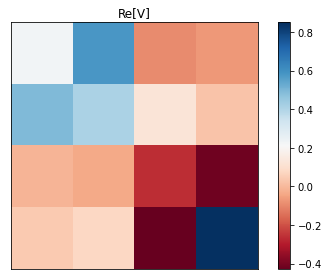

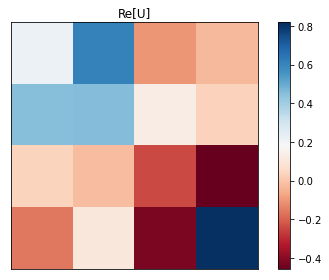

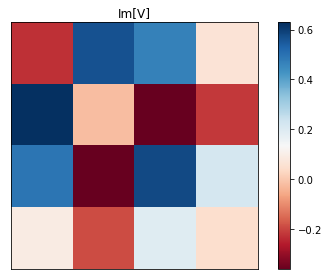

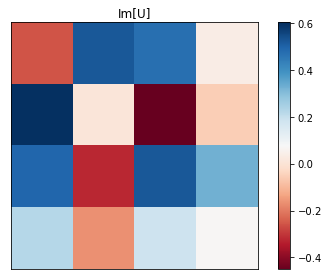

In [23]:
#Plots to for better visualization
plt.figure()
plt.title('Re[V]')
plt.imshow(np.real(Unitary), cmap = 'RdBu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Re[U]')
plt.imshow(np.real(Target_unitary), cmap = 'RdBu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Im[V]')
plt.imshow(np.imag(Unitary), cmap = 'RdBu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Im[U]')
plt.imshow(np.imag(Target_unitary), cmap = 'RdBu')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [53]:
#Making a random unitary from a random circuit
rand_unitary_prog = sf.Program(n_modes)

# #The theta and phi arrays for the beam splitters, rotation gates, etc.
Rot_thetas = np.array([0.5719, -1.9782, 2.0603, 0.0644, 0.345, 0.6782, 0,6754, 0.8965])
BS_thetas = np.array([0.7804, 0.06406, 0.473, 0.563, 0.1323, 0.311, 0.4348, 0.4368])
BS_phis = np.array([0.8578, 0.5165, 0.1176, 0.1517, 0.9946, 0.3231, 0.0798, 0.6157])

with rand_unitary_prog.context as q:
    #q is a list of the modes
    #Rotations for mode quadratures
    ops.Rgate(Rot_thetas[0])  | q[0]
    ops.Rgate(Rot_thetas[1])  | q[1]
    ops.Rgate(Rot_thetas[2])  | q[2]
    ops.Rgate(Rot_thetas[3])  | q[3]
    #Beam splitter array for entanglement
    ops.BSgate(BS_thetas[0], BS_phis[0])  | (q[0], q[1])
    ops.BSgate(BS_thetas[1], BS_phis[1]) | (q[2], q[3])
    ops.BSgate(BS_thetas[2], BS_phis[2])   | (q[1], q[2])
    ops.BSgate(BS_thetas[3], BS_phis[3])   | (q[0], q[1])
    ops.BSgate(BS_thetas[4], BS_phis[4])  | (q[2], q[3])
    ops.BSgate(BS_thetas[5], BS_phis[5])   | (q[1], q[2])
    ops.BSgate(BS_thetas[6], BS_phis[6])  | (q[0], q[1])
    ops.BSgate(BS_thetas[7], BS_phis[7])  | (q[2], q[3])
    #Rotations for mode quadratures
    ops.Rgate(Rot_thetas[4])  | q[0]
    ops.Rgate(Rot_thetas[5])  | q[1]
    ops.Rgate(Rot_thetas[6])  | q[2]
    ops.Rgate(Rot_thetas[7])  | q[3]
    #Beam splitter array for entanglement
    ops.BSgate(BS_thetas[0], BS_phis[0])  | (q[0], q[1])
    ops.BSgate(BS_thetas[1], BS_phis[1]) | (q[2], q[3])
    ops.BSgate(BS_thetas[2], BS_phis[2])   | (q[1], q[2])
#Extrac Target Unitary
Unitary_gaus_symplectic = rand_unitary_prog.compile(compiler="gaussian_unitary")
Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
Target_unitary = np.round(Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4], 4)
print(Target_unitary)

[[-0.1797-0.4792j -0.0352+0.5463j -0.2172+0.621j  -0.0449+0.0597j]
 [ 0.1422+0.3333j  0.0748+0.8018j  0.0226-0.359j   0.2134-0.2129j]
 [ 0.0893+0.7116j -0.0268+0.0645j -0.2297+0.3745j -0.4313+0.3189j]
 [-0.0636+0.2972j  0.0419-0.2126j -0.3376+0.3616j  0.7367-0.2706j]]


In [66]:
'''Optimizer code for designing a photonic circuit with layers - i.e., 
no prior knowledge of structure of what the quantum circuit should look like
'''
np.random.seed(12)
#Variational parameters in one layer
params_per_layer = 12
#Number of layers
layers = 3
#Initializing variational parameters
var_params = np.random.rand(params_per_layer*layers)

def cost(params):
    #Creating strawberry fields program to get the unitary based on the current variational parameters
    prog = sf.Program(n_modes)
    with prog.context as q:
        for i in range (layers):
            #Rotations for mode quadratures
            ops.Rgate(params[0 + params_per_layer*i])  | q[0]
            ops.Rgate(params[1 + params_per_layer*i])  | q[1]
            ops.Rgate(params[2 + params_per_layer*i])  | q[2]
            ops.Rgate(params[3 + params_per_layer*i])  | q[3]
            #Beam splitter array for entanglement
            ops.BSgate(params[4 + params_per_layer*i], params[8 + params_per_layer*i])  | (q[0], q[1])
            ops.BSgate(params[5 + params_per_layer*i], params[9 + params_per_layer*i])  | (q[2], q[3])
            ops.BSgate(params[6 + params_per_layer*i], params[10 + params_per_layer*i])  | (q[1], q[2])
            ops.BSgate(params[7 + params_per_layer*i], params[11 + params_per_layer*i])  | (q[0], q[3])
    #Extract Unitary
    Unitary_gaus_symplectic = prog.compile(compiler="gaussian_unitary")
    Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
    Unitary = Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4]
    #Returns cost function
    return -np.real(np.trace(np.matmul(Unitary, Target_unitary.conj().T)))

print(cost(var_params))
optimized_params = minimize(cost, var_params, method='nelder-mead', options={'xatol': 1e-8, 'maxiter': 20000, 'disp': True})

0.9524468380870066
Optimization terminated successfully.
         Current function value: -4.000007
         Iterations: 7054
         Function evaluations: 8826


In [67]:
print('The optimized parameters are:')
print(optimized_params.x)
print('The final value of the cost function is:')
print(optimized_params.fun)

The optimized parameters are:
[-2.18105373e-01  1.41720001e-01  4.19676906e-01  4.91575822e-01
  3.83110409e-02  1.23285911e-01 -1.16916343e+00  2.46820672e-02
  2.29749058e+00  1.10881629e-01  6.27742650e-01  9.30061394e-01
 -7.22488000e-01 -4.48636738e-01  1.53779425e-04  7.25863380e-01
  1.06707328e+00  9.05185210e-01  6.00449627e-01  2.73998766e-01
  1.47661684e+00  2.11156270e-02  6.20618230e-02  1.02490036e-01
  3.85300008e-01  5.54309920e-01  5.01555114e-01 -5.13555813e-01
  4.77269231e-01  1.54802396e+00  9.77903670e-01  6.15405168e-01
  7.90625139e-01  1.21042041e+00  6.22945780e-01  1.45380714e+00]
The final value of the cost function is:
-4.000006822613162


[[-0.1797-0.4792j -0.0352+0.5463j -0.2172+0.621j  -0.0449+0.0597j]
 [ 0.1422+0.3333j  0.0748+0.8018j  0.0226-0.359j   0.2134-0.2129j]
 [ 0.0893+0.7116j -0.0268+0.0645j -0.2297+0.3745j -0.4313+0.3189j]
 [-0.0636+0.2972j  0.0419-0.2126j -0.3376+0.3616j  0.7367-0.2706j]]
[[-0.1797-0.4792j -0.0352+0.5463j -0.2172+0.621j  -0.0449+0.0597j]
 [ 0.1422+0.3333j  0.0748+0.8018j  0.0226-0.359j   0.2134-0.2129j]
 [ 0.0893+0.7116j -0.0268+0.0645j -0.2297+0.3745j -0.4313+0.3189j]
 [-0.0636+0.2972j  0.0419-0.2126j -0.3376+0.3616j  0.7367-0.2706j]]


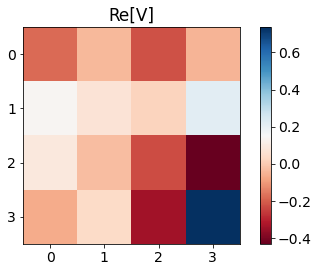

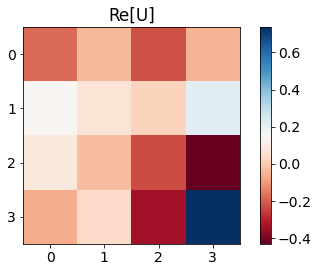

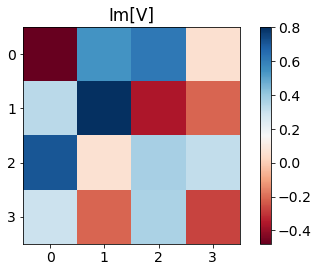

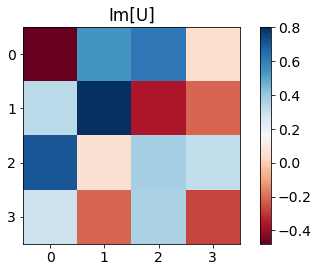

In [68]:
#Testing Unitary of optimized parameters
prog_opt = sf.Program(n_modes)
#Creating strawberry fields program to get the unitary based on the current variational parameters
with prog_opt.context as q:
    for i in range (layers):
        #Rotations for mode quadratures
        ops.Rgate(optimized_params.x[0 + params_per_layer*i])  | q[0]
        ops.Rgate(optimized_params.x[1 + params_per_layer*i])  | q[1]
        ops.Rgate(optimized_params.x[2 + params_per_layer*i])  | q[2]
        ops.Rgate(optimized_params.x[3 + params_per_layer*i])  | q[3]
        #Beam splitter array for entanglement
        ops.BSgate(optimized_params.x[4 + params_per_layer*i], optimized_params.x[8 + params_per_layer*i])  | (q[0], q[1])
        ops.BSgate(optimized_params.x[5 + params_per_layer*i], optimized_params.x[9 + params_per_layer*i])  | (q[2], q[3])
        ops.BSgate(optimized_params.x[6 + params_per_layer*i], optimized_params.x[10 + params_per_layer*i])  | (q[1], q[2])
        ops.BSgate(optimized_params.x[7 + params_per_layer*i], optimized_params.x[11 + params_per_layer*i])  | (q[0], q[3])
#Extract Unitary
Unitary_gaus_symplectic = prog_opt.compile(compiler="gaussian_unitary")
Unitary_symplectic = Unitary_gaus_symplectic.circuit[0].op.p[0]
Unitary = Unitary_symplectic[:4, :4] + 1j*Unitary_symplectic[4:, :4]
print(np.round(Unitary, 4))
print(Target_unitary)

matplotlib.rcParams.update({'font.size': 14})
#Plots to for better visualization
plt.figure()
plt.title('Re[V]')
plt.imshow(np.real(Unitary), cmap = 'RdBu')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Re[U]')
plt.imshow(np.real(Target_unitary), cmap = 'RdBu')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Im[V]')
plt.imshow(np.imag(Unitary), cmap = 'RdBu')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Im[U]')
plt.imshow(np.imag(Target_unitary), cmap = 'RdBu')
plt.colorbar()
plt.tight_layout()
plt.show()

In [69]:
cost_functions.append(optimized_params.fun)

In [40]:
import matplotlib

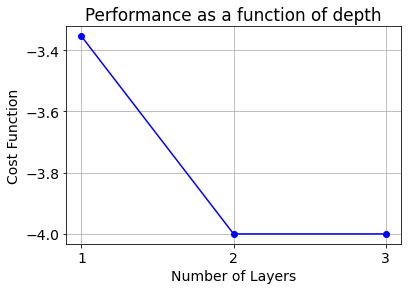

In [70]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure()
plt.title('Performance as a function of depth')
plt.plot([1, 2, 3], cost_functions, 'bo')
plt.plot([1, 2, 3], cost_functions, 'b')
plt.xlabel('Number of Layers')
plt.xticks([1, 2, 3])
plt.ylabel('Cost Function')
plt.grid()
#plt.tight_layout()
plt.show()